<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

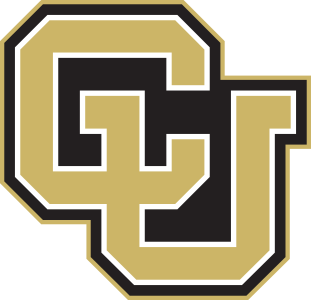

# Lecture 10, hands-on: PyTorch, CNNs
*(CPBS 7602: Introduction to Big Data in the Biomedical Sciences)*

By __Milton Pividori__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

# Data setup
- Make sure your environment has the following packages:
  - PyTorch ([installation instructions](https://pytorch.org/get-started/locally/)); you shouldn't need `torchvision`:
    ```bash
    pip3 install torch --index-url https://download.pytorch.org/whl/cu126
    ```

## Example 1: Logistic Regression with PyTorch

Adapted from [pytorch-logistic-regression](https://github.com/carlosrcoelho/pytorch-logistic-regression/blob/main/pytorch_logistic_regression.ipynb)

In [1]:
!pip3 install torch --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

### Prepare the data

In [3]:
# Prepare data

bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target

n_samples, n_features = X.shape
print(n_samples, n_features)

569 30


In [4]:
# split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [5]:
# scale data

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
# convert to tensors

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [7]:
# reshape y tensors

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

In [8]:
y_train.shape

torch.Size([455, 1])

In [9]:
y_test.shape

torch.Size([114, 1])

### Prepare model

In [10]:
# Create model
# f = wx + b, sigmoid at the end

class LogisticRegression(nn.Module):

    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted
    
model = LogisticRegression(n_features)

### Loss and Optimizer

In [11]:
# Loss and optimizer
# Note: We're using SGD (Stochastic Gradient Descent) optimizer here.
# This is a simple, classic optimizer. Example 2 will use Adam, a more sophisticated optimizer.

learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Training Loop

**Note:** This example processes the entire dataset in each iteration (no mini-batches).
This works for small datasets like this one, but larger datasets require batch processing (see Example 2).

In [12]:
num_epochs = 100

for epoch in range(num_epochs):
    # zero gradients from previous iteration
    optimizer.zero_grad()

    # forward pass and loss
    y_predicted = model(X_train)
    loss = criterion(y_predicted, y_train)

    # backward pass (compute gradients)
    loss.backward()

    # update weights
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 10, loss = 0.7294
epoch: 20, loss = 0.5868
epoch: 30, loss = 0.4947
epoch: 40, loss = 0.4322
epoch: 50, loss = 0.3875
epoch: 60, loss = 0.3541
epoch: 70, loss = 0.3280
epoch: 80, loss = 0.3068
epoch: 90, loss = 0.2893
epoch: 100, loss = 0.2744


### Evaluate Model

In [13]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    y_predicted = model(X_test)  # no need to call model.forward()
    y_predicted_cls = y_predicted.round()   # round off to nearest class
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])  # accuracy
    print(f'accuracy = {acc:.4f}')

accuracy = 0.8684


### Question 1

How does this compare with the LogisticRegression implementation in scikit-learn?

In [14]:
# implement logistic regression with sklearn
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)
print(f'sklearn accuracy = {clf.score(X_test, y_test):.4f}')

sklearn accuracy = 0.9561


/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/utils/validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


_Answer_: The sklearn implementation of a logisitic regression model is more accurate than the PyTorch implementation. This difference is likely due to the different default parameters each uses. Sklearn uses L2 regularization and lbgfs solver by default, whereas in the PyTorch implementation, a sigmoid activation function and stochastic gradient descent are used. 

## Example 2: Multi-layer Perceptron (MLP) with PyTorch

Adapted from [medium](https://medium.com/@mn05052002/building-a-simple-mlp-from-scratch-using-pytorch-7d50ca66512b).

**Key differences from Example 1:**
- Uses **mini-batch processing** with DataLoader (essential for larger datasets and deeper networks)
- Uses **Adam optimizer** instead of SGD (Adam adapts learning rates automatically)
- Implements proper **train/eval modes** (important when using dropout or batch normalization)
- More complex architecture with **multiple hidden layers**

### Import modules

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons, load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Prepare the data

Pick below a dataset you would like to test

In [16]:
# # Generate synthetic  dataset
#X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)

In [17]:
# Use real dataset
X, y = load_iris(return_X_y=True)

In [18]:
# data splitting

num_features = X.shape[1]
num_labels = np.unique(y).shape[0]

X_train, X_test, y_train_idx, y_test_idx = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

<Axes: >

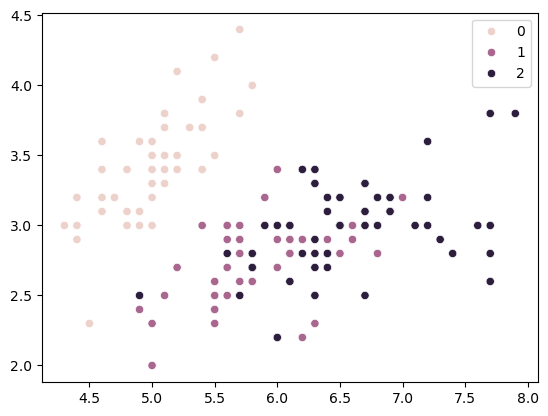

In [19]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

In [20]:
# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
X_train.shape

(120, 4)

In [22]:
y_train_tensor.shape

torch.Size([120])

### Prepare model

In [23]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=None):
        super(MLP, self).__init__()
        
        # Create list to hold all layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        if dropout_rate is not None:
            layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            if dropout_rate is not None:
                layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        # layers.append(nn.Sigmoid())  # For binary classification
        
        # Combine all layers into a sequential model
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

### Loss and Optimizer

In [24]:
# Define model hyperparameters
input_size = num_features  # Our data has 4 (Iris) features
hidden_sizes = [64, 32]  # Two hidden layers with 64 and 32 neurons
output_size = num_labels  # Number of classes (3 for Iris)

# Create the model
model = MLP(input_size, hidden_sizes, output_size)#, dropout_rate=0.2)
print(model)

# Define loss function and optimizer
# CrossEntropyLoss is the standard choice for multi-class classification
# It combines LogSoftmax and NLLLoss, so we don't need softmax in the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

MLP(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=3, bias=True)
  )
)


### Training Loop

In [25]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    # Lists to store metrics
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # training loop
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        # Calculate epoch loss
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # validation loop
        model.eval()
        test_loss = 0.0
        
        # No gradient calculation needed for evaluation
        with torch.no_grad():
            for inputs, targets in test_loader:
                # Forward pass
                outputs = model(inputs)
                
                # Calculate loss
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            
            val_epoch_loss = test_loss / len(test_loader.dataset)
            val_losses.append(val_epoch_loss)
        
        # Print progress
        if (epoch+1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    
    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=20)

Epoch 5/20, Loss: 0.6915
Epoch 10/20, Loss: 0.3935
Epoch 15/20, Loss: 0.2697
Epoch 20/20, Loss: 0.1863


### Evaluate Model

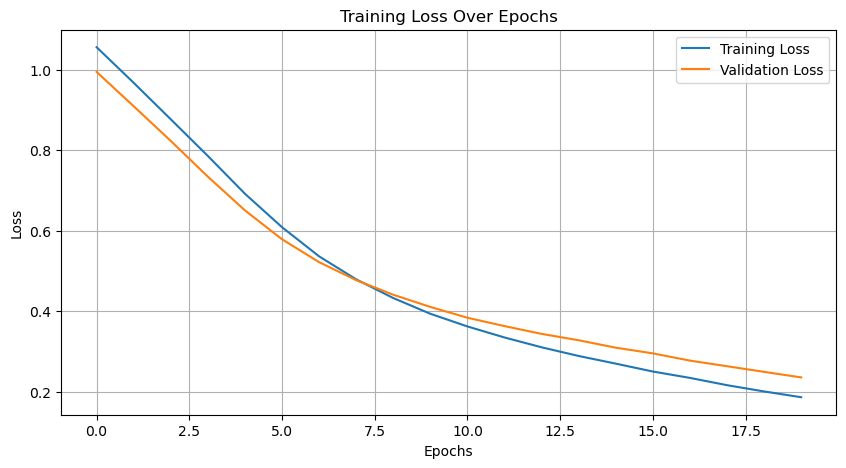

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Evaluate model accuracy on test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        preds_class = logits.argmax(dim=1)

        correct += (preds_class == yb).sum().item()
        total += xb.size(0)

test_acc = correct / total
print(f"\nTest accuracy: {test_acc * 100:.4f}%")


Test accuracy: 90.0000%


### Question 2

Looking at the training and validation losses (curves above), what would be a strategy to improve accuracy on the test set?

_Answer_: To improve accuracy on the test set, hyperparameter sweeping and cross validation or early stopping could be used.

### Question 3

Compare your logistic regression model implemented in PyTorch with the MLP in the breast cancer dataset (from Example 1).

In [28]:
# compare with sklearn implementation
clf = LogisticRegression()
clf.fit(X_train, y_train_idx)
print(f'sklearn accuracy = {clf.score(X_test, y_test_idx):.4f}')

sklearn accuracy = 0.9333


_Answer_: Compared to the sklearn implementation, sklearn logistic regression does worse in terms of accuracy. 

### Question 4

Compare your logistic regression model implemented in PyTorch with the MLP using the Moons dataset (from Example 2).

In [29]:
#note doing with iris dataset because moons dataset was used first

# compare with sklearn implementation
clf = LogisticRegression()
clf.fit(X_train, y_train_idx)
print(f'sklearn accuracy = {clf.score(X_test, y_test_idx):.4f}')

sklearn accuracy = 0.9333


_Answer_: The performance (evaluated with accuracy) of logistic regression implementation for the iris dataset using sklearn is the same as the implementation using PyTorch.

## Example 3: Predicting handwritten digits with CNNs

In [4]:
from sklearn.datasets import load_digits

### Prepare the data

In [5]:
digits = load_digits()
X = digits.images
y = digits.target

In [6]:
X.shape

(1797, 8, 8)

In [7]:
y.shape

(1797,)

In [8]:
X.max()

np.float64(16.0)

In [9]:
# normalize to [0, 1] and add channel dimension (C=1)
# original data is in [0, 16]
X = X / 16.0
# shape: (n_samples, 1, 8, 8)
X = X[:, None, :, :]

In [10]:
X.shape

(1797, 1, 8, 8)

In [11]:
X[0]

array([[[0.    , 0.    , 0.3125, 0.8125, 0.5625, 0.0625, 0.    , 0.    ],
        [0.    , 0.    , 0.8125, 0.9375, 0.625 , 0.9375, 0.3125, 0.    ],
        [0.    , 0.1875, 0.9375, 0.125 , 0.    , 0.6875, 0.5   , 0.    ],
        [0.    , 0.25  , 0.75  , 0.    , 0.    , 0.5   , 0.5   , 0.    ],
        [0.    , 0.3125, 0.5   , 0.    , 0.    , 0.5625, 0.5   , 0.    ],
        [0.    , 0.25  , 0.6875, 0.    , 0.0625, 0.75  , 0.4375, 0.    ],
        [0.    , 0.125 , 0.875 , 0.3125, 0.625 , 0.75  , 0.    , 0.    ],
        [0.    , 0.    , 0.375 , 0.8125, 0.625 , 0.    , 0.    , 0.    ]]])

In [12]:
# Train/val split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

In [16]:
# Create DataLoaders
batch_size = 64

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

### Prepare model

In [17]:
# Define a simple CNN for 8x8 images
class DigitCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # input: (1, 8, 8)
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # -> (16, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(2),                            # -> (16, 4, 4)

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # -> (32, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> (32, 2, 2)
        )

        # after convs: 32 channels, 2x2 => 32 * 2 * 2 = 128 features
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 2 * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 10)  # 10 classes: digits 0-9
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [18]:
# training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitCNN().to(device)

### Loss and Optimizer

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Training Loop

In [20]:
num_epochs = 15

for epoch in range(num_epochs):
    # Train
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Evaluate
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    accuracy = correct / total
    print(f"Epoch {epoch+1:02d}/{num_epochs}  "
          f"Loss: {epoch_loss:.4f}  "
          f"Test Acc: {accuracy:.4f}")

Epoch 01/15  Loss: 2.2820  Test Acc: 0.5444
Epoch 02/15  Loss: 2.1648  Test Acc: 0.6667
Epoch 03/15  Loss: 1.7916  Test Acc: 0.7389
Epoch 04/15  Loss: 1.1363  Test Acc: 0.8083
Epoch 05/15  Loss: 0.6784  Test Acc: 0.8722
Epoch 06/15  Loss: 0.4562  Test Acc: 0.8889
Epoch 07/15  Loss: 0.3471  Test Acc: 0.8917
Epoch 08/15  Loss: 0.2825  Test Acc: 0.9083
Epoch 09/15  Loss: 0.2400  Test Acc: 0.9194
Epoch 10/15  Loss: 0.2030  Test Acc: 0.9250
Epoch 11/15  Loss: 0.1794  Test Acc: 0.9333
Epoch 12/15  Loss: 0.1632  Test Acc: 0.9278
Epoch 13/15  Loss: 0.1486  Test Acc: 0.9472
Epoch 14/15  Loss: 0.1294  Test Acc: 0.9389
Epoch 15/15  Loss: 0.1235  Test Acc: 0.9528


### Example predictions on single samples

In [46]:
# Example: predict on one sample
model.eval()
i = 0
with torch.no_grad():
    sample = X_test_t[i:(i+1)].to(device)     # shape (1, 1, 8, 8)
    logits = model(sample)
    pred = logits.argmax(dim=1).item()

print("True label:", y_test[i])
print("Predicted :", pred)

True label: 5
Predicted : 5


### Question 5

How does this compare with the MLP we trained in lecture 1?

_Answer_: compared to the MLP that was trained in lecture 1, 

### Challenge

Try to fine-tune your CNN model to obtain maximum accuracy on the test set.

In [21]:
# new DataLoaders for the CNN
train_digits_ds = TensorDataset(X_train_t, y_train_t)
test_digits_ds = TensorDataset(X_test_t, y_test_t)

train_digits_loader = DataLoader(train_digits_ds, batch_size=32, shuffle=True)
test_digits_loader = DataLoader(test_digits_ds, batch_size=32, shuffle=False)

Improvements:
1. Architecture:
    - batch normalization for training
        - reduces input variability 
        - faster model convergence
    - dropout
        - prevents overfitting & improves generalizability
    - deeper CNN (4 conv layers)
    - larger filters
        - 1->32->32->64->64
        - learns largers patterns faster
    - more and larger fully connected layers
        - 3 layers
        - 256->128->64->10
            - can represent more complex relationships

2. Training:
    - weight decay
        - prevents overfitting by continuously shrinking weights to avoid learning noise

In [37]:
# improved CNN 
class ImprovedDigitsCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        
        # convolutional layers with batch normalization
        self.conv_layers = nn.Sequential(
            # first conv layer
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # -> (32, 8, 8)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # second conv layer with max pooling & dropout
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # -> (32, 8, 8)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> (32, 4, 4)
            nn.Dropout2d(dropout_rate * 0.5),
            
            # third conv layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> (64, 4, 4)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # fourth conv layer with max pooling & dropout
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # -> (64, 4, 4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> (64, 2, 2)
            nn.Dropout2d(dropout_rate),

            # fifth conv layer
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # -> (128, 2, 2)
            nn.BatchNorm2d(128),  
            nn.ReLU(),

            # sixth conv layer 
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # -> (128, 2, 2)
            nn.BatchNorm2d(128),  
            nn.ReLU(),
            nn.MaxPool2d(2),      # -> (128, 1, 1)                   
            nn.Dropout2d(dropout_rate)

        )

        # fully connected layers with batch normalization and dropout
        # After conv layers: 128 channels * 1 * 1 = 128 features
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 1 * 1, 128),  # 128 -> 128
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),           # 128 -> 64
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(64, 10)             # 64 -> 10 classes: digits 0-9
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model_digits = ImprovedDigitsCNN().to(device)

In [33]:
# training function for CNN
def train_digits_model(model, train_loader, test_loader, num_epochs=50):
    # set up
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    
    train_accuracies = []
    test_accuracies = []
    
    best_test_acc = 0.0
    
    for epoch in range(num_epochs):
        # training
        model.train()
        train_correct = 0
        train_total = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()
        
        train_acc = train_correct / train_total
        train_accuracies.append(train_acc)
        
        # model evaluation
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                test_total += y_batch.size(0)
                test_correct += (predicted == y_batch).sum().item()
        
        test_acc = test_correct / test_total
        test_accuracies.append(test_acc)
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
        
        # print accuracy every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:2d}/{num_epochs} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    print(f'\nBest Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)')
    return train_accuracies, test_accuracies, best_test_acc

In [38]:
# train improved CNN model
train_acc, test_acc, best_acc = train_digits_model(model_digits, train_digits_loader, test_digits_loader, num_epochs=50)

Epoch 10/50 - Train Acc: 0.9826, Test Acc: 0.9889
Epoch 20/50 - Train Acc: 0.9903, Test Acc: 0.9778
Epoch 20/50 - Train Acc: 0.9903, Test Acc: 0.9778
Epoch 30/50 - Train Acc: 0.9875, Test Acc: 0.9917
Epoch 30/50 - Train Acc: 0.9875, Test Acc: 0.9917
Epoch 40/50 - Train Acc: 0.9930, Test Acc: 0.9750
Epoch 40/50 - Train Acc: 0.9930, Test Acc: 0.9750
Epoch 50/50 - Train Acc: 0.9833, Test Acc: 0.9917

Best Test Accuracy: 0.9972 (99.72%)
Epoch 50/50 - Train Acc: 0.9833, Test Acc: 0.9917

Best Test Accuracy: 0.9972 (99.72%)


In [39]:
# evaluation of the model
model_digits.eval()
all_predictions = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in test_digits_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model_digits(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_true.extend(y_batch.cpu().numpy())

print("\nClassification Report:")
digit_names = [str(i) for i in range(10)] 
print(classification_report(all_true, all_predictions, target_names=digit_names))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.97      0.97      0.97        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       1.00      1.00      1.00        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       1.00      1.00      1.00        36
           8       0.94      0.97      0.96        35
           9       1.00      1.00      1.00        36

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



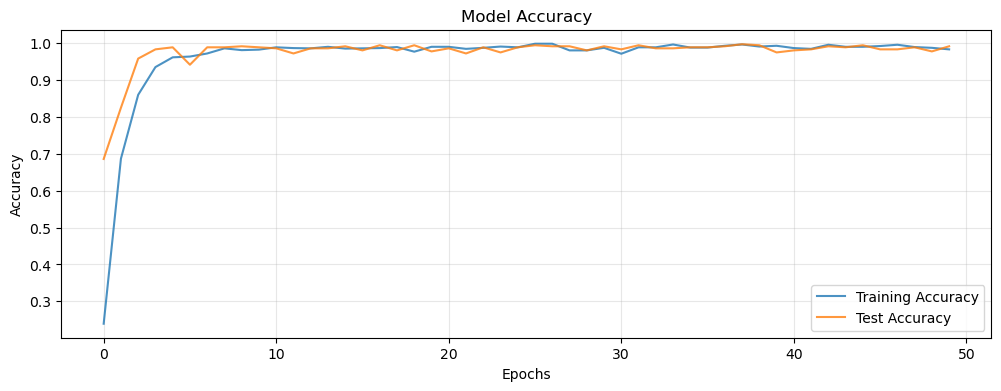

In [40]:
# plot accuracy
plt.figure(figsize=(12, 4))
plt.plot(train_acc, label='Training Accuracy', alpha=0.8)
plt.plot(test_acc, label='Test Accuracy', alpha=0.8)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()